# 13 Linear Algebra: Singular Value Decomposition

One can always decompose a matrix $\mathsf{A}$ 

\begin{gather}
\mathsf{A} = \mathsf{U}\,\text{diag}(w_j)\,\mathsf{V}^{T}\\
\mathsf{U}^T \mathsf{U} = \mathsf{U} \mathsf{U}^T = 1\\
\mathsf{V}^T \mathsf{V} = \mathsf{V} \mathsf{V}^T = 1
\end{gather}

where $\mathsf{U}$ and $\mathsf{V}$ are orthogonal matrices and the $w_j$ are the _singular values_ that are assembled into a diagonal matrix $\mathsf{W}$.

$$
\mathsf{W} = \text{diag}(w_j)
$$

The inverse (if it exists) can be directly calculated from the SVD:

$$
\mathsf{A}^{-1} = \mathsf{V} \text{diag}(1/w_j) \mathsf{U}^T
$$

## Solving ill-conditioned coupled linear equations 

In [1]:
import numpy as np

### Non-singular matrix 
Solve the linear system of equations

$$
\mathsf{A}\mathbf{x} = \mathbf{b}
$$

Using the standard linear solver in numpy:

In [2]:
A = np.array([
        [1, 2, 3],
        [3, 2, 1],
        [-1, -2, -6],
    ])
b = np.array([0, 1, -1])

In [3]:
np.linalg.solve(A, b)

array([ 0.83333333, -0.91666667,  0.33333333])

Using the inverse from SVD:

$$
\mathbf{x} = \mathsf{A}^{-1} \mathbf{b}
$$

In [4]:
U, w, VT = np.linalg.svd(A)
print(w)

[ 7.74140616  2.96605874  0.52261473]


First check that the SVD really factors $\mathsf{A} = \mathsf{U}\,\text{diag}(w_j)\,\mathsf{V}^{T}$:

In [5]:
U.dot(np.diag(w).dot(VT))

array([[ 1.,  2.,  3.],
       [ 3.,  2.,  1.],
       [-1., -2., -6.]])

In [6]:
np.allclose(A, U.dot(np.diag(w).dot(VT)))

True

Now calculate the matrix inverse $\mathsf{A}^{-1} = \mathsf{V} \text{diag}(1/w_j) \mathsf{U}^T$:

In [7]:
inv_w = 1/w
print(inv_w)

[ 0.1291755   0.33714774  1.91345545]


In [8]:
A_inv = VT.T.dot(np.diag(inv_w)).dot(U.T)
print(A_inv)

[[ -8.33333333e-01   5.00000000e-01  -3.33333333e-01]
 [  1.41666667e+00  -2.50000000e-01   6.66666667e-01]
 [ -3.33333333e-01  -1.08335035e-16  -3.33333333e-01]]


Check that this is the same that we get from `numpy.linalg.inv()`:

In [9]:
np.allclose(A_inv, np.linalg.inv(A))

True

Now, *finally* solve (and check against `numpy.linalg.solve()`):

In [10]:
x = A_inv.dot(b)
print(x)
np.allclose(x, np.linalg.solve(A, b))

[ 0.83333333 -0.91666667  0.33333333]


True

In [11]:
A.dot(x)

array([ -7.77156117e-16,   1.00000000e+00,  -1.00000000e+00])

In [12]:
np.allclose(A.dot(x), b)

True

### Singular matrix

If the matrix $\mathsf{A}$ is *singular* (i.e., its rank (linearly independent rows or columns) is less than its dimension and hence the linear system of equation does not have a unique solution):

For example, the following matrix has the same row twice:

In [13]:
C = np.array([
     [ 0.87119148,  0.9330127,  -0.9330127],
     [ 1.1160254,   0.04736717, -0.04736717],
     [ 1.1160254,   0.04736717, -0.04736717],
    ])
b1 = np.array([ 2.3674474,  -0.24813392, -0.24813392])
b2 = np.array([0, 1, 1])

In [14]:
np.linalg.solve(C, b1)

LinAlgError: Singular matrix

NOTE: failure is not always that obvious: numerically, a matrix can be *almost* singular.

Try solving the linear system of equations 

$$
\mathsf{D}\mathbf{x} = \mathbf{b}_1
$$
with matrix $\mathsf{D}$ below:

In [15]:
D = C.copy()
D[2, :] = C[0] - 3*C[1]
D

array([[ 0.87119148,  0.9330127 , -0.9330127 ],
       [ 1.1160254 ,  0.04736717, -0.04736717],
       [-2.47688472,  0.79091119, -0.79091119]])

In [16]:
np.linalg.solve(D, b1)

array([  1.61493184e+00,   2.69013663e+16,   2.69013663e+16])

Note that some of the values are huge, and suspiciously like the inverse of machine precision? Sign of a nearly singular matrix.

**Note**: *Just because a function did not throw an exception it does not mean that the answer is correct.* **Always check your output!**

Now back to the example with $\mathsf{C}$:

#### SVD for singular matrices
If a matrix is *singular* or *near singular* then one can *still* apply SVD. 

One can then compute the *pseudo inverse*

\begin{align}
\mathsf{A}^{-1} &= \mathsf{V} \text{diag}(\alpha_j) \mathsf{U}^T \\
\alpha_j &= \begin{cases}
 \frac{1}{w_j}, &\quad\text{if}\ w_j \neq 0\\
 0, &\quad\text{if}\ w_j = 0
 \end{cases}
\end{align}

i.e., any singular $w_j = 0$ is being "augmented" by setting

$$
\frac{1}{w_j} \rightarrow 0 \quad\text{if}\quad w_j = 0
$$

in $\text{diag}(1/w_j)$.

Perform the SVD for the singular matrix $\mathsf{C}$:

In [56]:
U, w, VT = np.linalg.svd(C)
print(w)

[  1.99999999e+00   1.00000000e+00   2.46519033e-32]


Note the third value $w_2 \approx 0$: sign of a singular matrix.

Test that the SVD really decomposes $\mathsf{A} = \mathsf{U}\,\text{diag}(w_j)\,\mathsf{V}^{T}$:

In [57]:
U.dot(np.diag(w).dot(VT))

array([[ 0.87119148,  0.9330127 , -0.9330127 ],
       [ 1.1160254 ,  0.04736717, -0.04736717],
       [ 1.1160254 ,  0.04736717, -0.04736717]])

In [58]:
np.allclose(C, U.dot(np.diag(w).dot(VT)))

True

There are the **singular values** (let's say, $|w_i| < 10^{-12}$):

In [59]:
singular_values = np.abs(w) < 1e-12
print(singular_values)

[False False  True]


#### Pseudo-inverse

Calculate the **pseudo-inverse** from the SVD

\begin{align}
\mathsf{A}^{-1} &= \mathsf{V} \text{diag}(\alpha_j) \mathsf{U}^T \\
\alpha_j &= \begin{cases}
 \frac{1}{w_j}, &\quad\text{if}\ w_j \neq 0\\
 0, &\quad\text{if}\ w_j = 0
 \end{cases}
\end{align}


Augment:

In [60]:
inv_w = 1/w
inv_w[singular_values] = 0
print(inv_w)

[ 0.5  1.   0. ]


In [61]:
C_inv = VT.T.dot(np.diag(inv_w)).dot(U.T)
print(C_inv)

[[-0.04736717  0.46650635  0.46650635]
 [ 0.5580127  -0.21779787 -0.21779787]
 [-0.5580127   0.21779787  0.21779787]]


#### Solution for $\mathbf{b}_1$  

Now solve the linear problem with SVD:

In [62]:
x1 = C_inv.dot(b1)
print(x1)

[-0.34365138  1.4291518  -1.4291518 ]


In [63]:
C.dot(x1) 

array([ 2.3674474 , -0.24813392, -0.24813392])

In [64]:
np.allclose(C.dot(x1), b1)

True

Thus, using the pseudo-inverse $\mathsf{C}^{-1}$ we can obtain solutions to the equation

$$
\mathsf{C} \mathbf{x}_1 = \mathbf{b}_1
$$

However, $\mathbf{x}_1$ is not the only solution: there's a whole line of solutions that are formed by the special solution and a combination of the basis vectors in the *null space* of the matrix:

The (right) *kernel* or *null space* contains all vectors $\mathbf{x^0}$ for which

$$
\mathsf{C} \mathbf{x^0} = 0
$$

(The dimension of the null space corresponds to the number of singular values.) You can find a basis that spans the null space. Any linear combination of null space basis vectors will also end up in the null space when $\mathbf{A}$ is applied to it.


Specifically, if $\mathbf{x}_1$ is a special solution and $\lambda_1 \mathbf{x}^0_1 + \lambda_2 \mathbf{x}^0_2 + \dots$ is a vector in the null space then

$$
\mathbf{x} = \mathbf{x}_1 + ( \lambda_1 \mathbf{x}^0_1 + \lambda_2 \mathbf{x}^0_2 + \dots )
$$

is **also a solution** because

$$
\mathsf{C} \mathbf{x} = \mathsf{C} \mathbf{x^0} + \mathsf{C} ( \lambda_1 \mathbf{x}^0_1 + \lambda_2 \mathbf{x}^0_2 + \dots ) = \mathsf{C} \mathbf{x^0} + 0 = \mathbf{b}_1 + 0 = \mathbf{b}_1
$$

The $\lambda_i$ are arbitrary real numbers and hence there is an infinite number of solutions.

In SVD:

* The columns $U_{\cdot, i}$ of $\mathsf{U}$ (i.e. `U.T[i]` or `U[:, i]`) corresponding to non-zero $w_i$, i.e. $\{i : w_i \neq 0\}$, form the basis for the _range_ of the matrix $\mathsf{A}$.
* The columns $V_{\cdot, i}$ of $\mathsf{V}$ (i.e. `V.T[i]` or `V[:, i]`) corresponding to zero $w_i$, i.e. $\{i : w_i = 0\}$, form the basis for the _null space_ of the matrix $\mathsf{A}$.

In [65]:
x1

array([-0.34365138,  1.4291518 , -1.4291518 ])

The rank space comes from $\mathsf{U}^T$:

In [66]:
U.T

array([[ -7.07106782e-01,  -4.99999999e-01,  -4.99999999e-01],
       [  7.07106780e-01,  -5.00000001e-01,  -5.00000001e-01],
       [ -2.47010760e-16,  -7.07106781e-01,   7.07106781e-01]])

The basis vectors for the rank space (``~ bool_array`` applies a logical ``NOT`` operation to the entries in the boolean array so that we can pick out "not singular values"):

In [112]:
U.T[~singular_values]

array([[-0.70710678, -0.5       , -0.5       ],
       [ 0.70710678, -0.5       , -0.5       ]])

The null space comes from $\mathsf{V}^T$:

In [113]:
VT

array([[-0.8660254 , -0.35355339,  0.35355339],
       [-0.5       ,  0.61237244, -0.61237244],
       [-0.        , -0.70710678, -0.70710678]])

The basis vector for the null space:

In [114]:
VT[singular_values]

array([[-0.        , -0.70710678, -0.70710678]])

The component of $\mathbf{x}_1$ along the basis vector of the null space of $\mathsf{C}$ (here a 1D space) – note that this component is zero, i.e., the special solution lives in the rank space:

In [116]:
x1.dot(VT[singular_values][0])

2.2204460492503131e-16

We can create a family of solutions by adding vectors in the null space to the special solution $\mathbf{x}_1$, e.g. $\lambda_1 = 2$: 

In [117]:
lambda_1 = 2
x1_1 = x1 + lambda_1 * VT[2]
print(x1_1)

np.allclose(C.dot(x1_1), b1)

[-0.34365138  0.01493824 -2.84336536]


True

Thus, **all** solutions are
```
x1 + lambda * VT[2]
```


#### Solution for  $\mathbf{b}_2$

The solution vector $x_2$ solves
$$
\mathsf{C}\mathbf{x}_2 = \mathbf{b}_2
$$

In [120]:
b2

array([0, 1, 1])

In [43]:
x2 = C_inv.dot(b2)
print(x2)
print(C.dot(x2))
np.allclose(C.dot(x2), b2)

[ 0.9330127  -0.43559574  0.43559574]
[ -4.44089210e-16   1.00000000e+00   1.00000000e+00]


True

... and the general solution will again be obtained by adding any multiple of the null space basis vector.

#### Null space 

The Null space is spanned by the following basis vectors (just one in this example):

In [40]:
null_basis = VT[singular_values]
null_basis

array([[-0.        , -0.70710678, -0.70710678]])

Show that 
$$
\mathsf{C}\mathbf{x}^0 = 0
$$

In [39]:
C.dot(null_basis.T)

array([[  0.00000000e+00],
       [ -6.93889390e-18],
       [ -6.93889390e-18]])

## SVD for fewer equations than unknowns
$N$ equations for $M$ unknowns with $N < M$:

* no unique solutions (underdetermined)
* $M-N$ dimensional family of solutions
* SVD: at least $M-N$ zero or negligible $w_j$: columns of $\mathsf{V}$ corresponding to singular $w_j$ span the solution space when added to a particular solution.

Same as the above [**Solving ill-conditioned coupled linear equations**](#Solving-ill-conditioned-coupled-linear-equations).

## SVD for more equations than unknowns
$N$ equations for $M$ unknowns with $N > M$:

* no exact solutions in general (overdetermined)
* but: SVD can provide best solution in the least-square sense
  $$
  \mathbf{x} = \mathsf{V}\, \text{diag}(1/w_j)\, \mathsf{U}^{T}\, \mathbf{b}
  $$
  where 

  * $\mathbf{x}$ is a $M$-dimensional vector of the unknowns (parameters of the fit),
  * $\mathsf{V}$ is a $M \times N$ matrix
  * the $w_j$ form a square $M \times M$ matrix,
  * $\mathsf{U}$ is a $M \times N$ matrix (and $\mathsf{U}^T$ is a $N \times M$ matrix), and
  * $\mathbf{b}$ is the $N$-dimensional vector of the given values (data)
  
It can be shown that $\mathbf{x}$ minimizes the residual

$$
\mathbf{r} := |\mathsf{A}\mathbf{x} - \mathbf{b}|.
$$

where the matrix $\mathsf{A}$ will be described below and will contain the evaluation of the fit function for each data point in $\mathbf{b}$.

(For a $N \le M$, one can find $\mathbf{x}$ so that $\mathbf{r} = 0$ – see above.)

(In the following, we will switch notation and denote the vector of $M$ unknown parameters of the model as $\mathbf{a}$; this $\mathbf{a}$ corresponds to $\mathbf{x}$ above. $N$ is the number of observations.)

### Linear least-squares fitting 

This is the *liner least-squares fitting problem*: Given $N$ data points $(x_i, y_i)$ (where $1 \le i \le N$), fit to a linear model $y(x)$, which can be any linear combination of $M$ functions of $x$.

For example, if we have $N$ functions $x^k$ with parameters $a_k$
$$
y(x) = a_1 + a_2 x + a_3 x^2 + \dots + a_M x^{M-1}
$$
or in general
$$
y(x) = \sum_{k=1}^M a_k X_k(x)
$$

The goal is to determine the $M$ coefficients $a_k$.

Define the **merit function**
$$
\chi^2 = \sum_{i=1}^N \left[ \frac{y_i - \sum_{k=1}^M a_k X_k(x_i)}{\sigma_i}\right]^2
$$
(sum of squared deviations, weighted with standard deviations $\sigma_i$ on the $y_i$).

Best parameters $a_k$ are the ones that *minimize $\chi^2$*.

*Design matrix* $\mathsf{A}$ ($N \times M$, $N \geq M$), vector of measurements $\mathbf{b}$ ($N$-dim) and parameter vector $\mathbf{a}$ ($M$-dim):

\begin{align}
A_{ij} &= \frac{X_j(x_i)}{\sigma_i}\\
b_i &= \frac{y_i}{\sigma_i}\\
\mathbf{a} &= (a_1, a_2, \dots, a_M)
\end{align}


The design matrix $\mathsf{A}$ contains the *predicted* values from the basis functions for all values $x_i$ of the independent variable $x$ for which we have measured data $y_i$. 

Minimum occurs when the derivative vanishes:
$$
0 = \frac{\partial\chi^2}{\partial a_k} = \sum_{i=1}^N {\sigma_i}^{-2} \left[ y_i - \sum_{j=1}^M a_j X_j(x_i) \right] X_k(x_i), \quad 1 \leq k \leq M
$$
($M$ coupled equations)

To simplify the notation, define the $M \times M$ matrix
\begin{align}
\alpha_{kj} &= \sum_{i=1}^N \frac{X_k(x_i) X_j(x_i)}{\sigma_i^2}\\
\mathsf{\alpha} &= \mathsf{A}^T \mathsf{A}
\end{align}
and the vector of length $M$
\begin{align}
\beta_{k} &= \sum_{i=1}^N \frac{y_i X_k(x_i)}{\sigma_i^2}\\
\boldsymbol{\beta} &= \mathsf{A}^T \mathbf{b}
\end{align}

Then the $M$ coupled equations can be compactly written as 
\begin{align}
\sum_{j=1}^{M} \alpha_{kj} a_j &= \beta_k\\
\mathsf{\alpha}\mathbf{a} = \boldsymbol{\beta}
\end{align}

$\mathsf{\alpha}$ and  $\boldsymbol{\beta}$ are known, so we have to solve this matrix equation for the vector of the unknown parameters $\mathbf{a}$.


#### Error estimates for the parameters

The inverse of $\mathsf{\alpha}$ is related to the uncertainties in the parameters:
$$
\mathsf{C} := \mathsf{\alpha}^{-1}
$$
in particular
$$
\sigma(a_i) = C_{ii}
$$
(and the $C_{ij}$ are the co-variances).

#### Solution of the linear least-squares fitting problem with SVD
We need to solve the overdetermined system of $M$ coupled equations
\begin{align}
\sum_{j=1}^{M} \alpha_{kj} a_j &= \beta_k\\
\mathsf{\alpha}\mathbf{a} = \boldsymbol{\beta}
\end{align}

SVD finds $\mathbf{a}$ that minimizes
$$
\chi^2 = |\mathsf{A}\mathbf{a} - \mathbf{b}|
$$

The errors are
$$
\sigma^2(a_j) = \sum_{i=1}^{M} \left(\frac{V_{ji}}{w_i}\right)^2
$$

#### Example
Synthetic data 

$$
y(x) = 3\sin x - 2\sin 3x + \sin 4x
$$

with noise $r$ added (uniform in range $-5 < r < 5$).

In [125]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

import numpy as np

In [126]:
def signal(x, noise=0):
    r = np.random.uniform(-noise, noise, len(x))
    return 3*np.sin(x) - 2*np.sin(3*x) + np.sin(4*x) + r

In [127]:
X = np.linspace(-10, 10, 500)
Y = signal(X, noise=5)

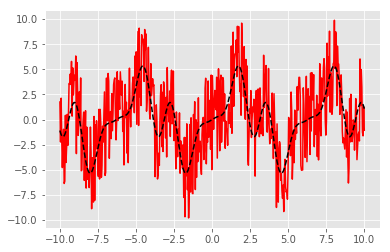

In [128]:
plt.plot(X, Y, 'r-', X, signal(X, noise=0), 'k--')

Define our fit function (the model) and the basis functions. We need the basis functions for setting up the problem and we will later use the fitfunction together with our parameter estimates to compare our fit to the true underlying function.

In [129]:
def fitfunc(x, a):
    return a[0]*np.cos(x) + a[1]*np.sin(x) + \
           a[2]*np.cos(2*x) + a[3]*np.sin(2*x) + \
           a[4]*np.cos(3*x) + a[5]*np.sin(3*x) + \
           a[6]*np.cos(4*x) + a[7]*np.sin(4*x)

def basisfuncs(x):
    return np.array([np.cos(x), np.sin(x), 
                     np.cos(2*x), np.sin(2*x), 
                     np.cos(3*x), np.sin(3*x), 
                     np.cos(4*x), np.sin(4*x)])

(Note that we could have used the `basisfuncs()` in `fitfunc()` – left as an exercise for the keen reader...)

Set up the $\mathsf{\alpha}$ matrix and the $\boldsymbol{\beta}$ vector (here we assume that all observations have the same error $\sigma = 1$):

In [131]:
M = 8
sigma = 1.
alpha = np.zeros((M, M))
beta = np.zeros(M)
for x in X:
    Xk = basisfuncs(x)
    for k in range(M):
        for j in range(M):
            alpha[k, j] += Xk[k]*Xk[j]
for x, y in zip(X, Y):
    beta += y * basisfuncs(x)/sigma

Finally, solving the problem follows the same procedure as before:

Get the SVD:

In [132]:
U, w, VT = np.linalg.svd(alpha)
V = VT.T

In this case, the singular values do not immediately show if any basis functions are superfluous (this would be the case for values close to 0).

In [133]:
w

array([ 296.92809624,  282.94804954,  243.7895787 ,  235.7300808 ,
        235.15938555,  235.14838812,  235.14821093,  235.14821013])

... nevertheless, remember to routinely mask any singular values or close to singular values:

In [134]:
w_inv = 1/w
w_inv[np.abs(w) < 1e-12] = 0
alpha_inv = V.dot(np.diag(w_inv)).dot(U.T)

Solve the system of equations with the pseudo-inverse:

In [135]:
a_values = alpha_inv.dot(beta)
print(a_values)

[ 0.02941343  3.15273275  0.22893881  0.14290046  0.30121258 -2.04230627
  0.28692984  1.08197408]


Compare the fitted values to the original parameters $a_j = 0, +3, 0, 0, 0, -2, 0, +1$.

The original parameters show up as 3.15, -2.04 and 1.08 but the other parameters also have appreciable values. Given that the noise was sizable, this is not unreasonable.

Compare the plot of the underlying true function ("signal", dashed line) to the model ("fit", solid line):

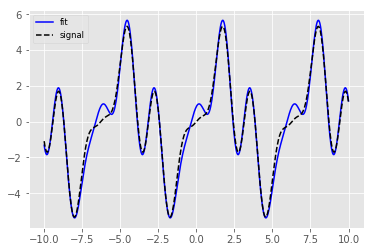

In [136]:
plt.plot(X, fitfunc(X, a_values), 'b-', label="fit")
plt.plot(X, signal(X, noise=0), 'k--', label="signal")
plt.legend(loc="best", fontsize="small")

We get some spurious oscillations but overall the result looks reasonable.